In [155]:
import numpy as np
import pandas as pd
import glob
import yaml
import yfinance as yf
import matplotlib.pyplot as plt
import json
import datetime
import requests
import re
import scipy
from bs4 import BeautifulSoup


with open('/app/pfanalyzer.yml') as f:
    config = yaml.safe_load(f.read())
print(config)

with open('/tmp/prices.json') as f:
    prices = json.loads(f.read())
print(prices)

{'assets': {'emaxis_slim_sp500': {'equivalent': 'SPY', 'equivalent_scale': 27825.4209446}, 'emaxis_slim_acwi': {'equivalent': 'ACWI', 'equivalent_scale': 6914.77577116}, 'nomura_nobl': {'equivalent': 'NOBL', 'equivalent_scale': 5604.49454688}, 'br_mmf': {'equivalent': 'usd', 'equivalent_scale': 1}, 'gs_mmf': {'equivalent': 'usd', 'equivalent_scale': 100}, '2036.T': {'leverage': 2, 'base': 'IAU'}, '2255.T': {'equivalent': 'TLT'}, '2256.T': {'equivalent': 'AGG'}, '2257.T': {'equivalent': 'LQD'}, '2258.T': {'equivalent': 'HYG'}, 'IAU': {'equivalent': 'GLD'}, 'TLT': {'asset_class': 'bond'}, 'AGG': {'asset_class': 'bond'}, 'LQD': {'asset_class': 'bond'}, 'HYG': {'asset_class': 'bond'}, 'GLD': {'asset_class': 'commodity'}, 'btc': {'asset_class': 'crypto'}, 'eth': {'asset_class': 'crypto'}, 'usd': {'asset_class': 'cash'}, 'jpy': {'asset_class': 'cash'}, 'ACWI': {'market_portfolio': True}, 'SPY': {'market_portfolio': True}}}
{'usd': 1.0, 'jpy': 0.006647168198428357, 'btc': 51577.171875, 'eth':

## Total assets

- m2 (nano): total_usd / frb_m2sl * 1e9
- richmanbtc market cap: market cap of richmanbtc investment grade assets
- richmanbtc investment grade assets: stock, gold, btc

## richmanbtc portfolio

- market cap weighted portfolio of richmanbtc investment grade assets.
- Compare with the total return of the portfolio.
- The value as of January 1, 2024, is set to 1 usd.

## world ranking

- estimated with wealth distribution
- https://en.wikipedia.org/wiki/Distribution_of_wealth
- todo

In [161]:
today = datetime.datetime.today().strftime("%Y-%m-%d")
url = f'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=718&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=M2SL&scale=left&cosd=2023-12-01&coed={today}&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date={today}&revision_date={today}&nd=1959-01-01'
m2 = pd.read_csv(url)['M2SL'].iloc[-1] * 1e9

stock_market_cap = 0.0
gold_market_cap = 0.0
btc_market_cap = 0.0
soup = BeautifulSoup(requests.get('https://8marketcap.com/').text)
for node in soup.select('span.banner-element'):
    t = node.get_text()
    if 'Companies' in t:
        stock_market_cap = float(re.match(r'.*\$([0-9\.]+).*', t.strip()).group(1)) * 1e12
    if 'Gold' in t:
        gold_market_cap = float(re.match(r'.*\$([0-9\.]+).*', t.strip()).group(1)) * 1e12
btc_market_cap = 2100e4 * prices['btc']
rich_market_cap = stock_market_cap + gold_market_cap + btc_market_cap

df_yf = yf.download(['VT', 'GLDM', 'BTC-USD'], start='2024-01-01')
df_yf = df_yf[['Close', 'Adj Close']].ffill().dropna()
weights = df_yf['Close'].copy()
weights['VT'] *= stock_market_cap / weights['VT'].iloc[-1]
weights['GLDM'] *= gold_market_cap / weights['GLDM'].iloc[-1]
weights['BTC-USD'] *= btc_market_cap / weights['BTC-USD'].iloc[-1]
weights /= weights.sum(axis=1).values.reshape(-1, 1)
rich_portfolio_ret = (1 + (df_yf['Adj Close'].pct_change() * weights.shift(1)).sum(axis=1)).dropna().cumprod()

print('market cap')
print('m2 (trillion)', m2 * 1e-12)
print('stock market cap (trillion)', stock_market_cap * 1e-12)
print('gold market cap (trillion)', gold_market_cap * 1e-12)
print('btc market cap (trillion)', btc_market_cap * 1e-12)
print('richmanbtc market cap (trillion)', rich_market_cap * 1e-12)
print('richmanbtc portfolio', rich_portfolio_ret.iloc[-1])

print('total assets')
df = pd.read_pickle('/tmp/df_processed.pkl')
total_usd = df['amount_usd'].sum()
print(total_usd, 'dollar')
print(total_usd / m2 * 1e9, 'm2 (nano)')
print(total_usd / rich_market_cap * 1e9, 'richmanbtc market cap(nano)')
print(total_usd / rich_portfolio_ret.iloc[-1], 'richmanbtc portfolio')

[*********************100%%**********************]  3 of 3 completed

market cap
m2 (trillion) 20.865199999999998
stock market cap (trillion) 101.745
gold market cap (trillion) 13.738
btc market cap (trillion) 1.0831206093749999
richmanbtc market cap (trillion) 116.56612060937499
richmanbtc portfolio 1.0467643626168779
total assets
1698591.1173854596 dollar
81.40785218380172 m2 (nano)
14.571910847729182 richmanbtc market cap(nano)
1622706.2919290024 richmanbtc portfolio


In [157]:
def get_country(row):
    ac = row['asset_class']
    asset = row['asset']
    if asset[-2:] == '.T' or asset == 'jpy':
        return 'jp'
    if ac == 'crypto':
        return 'global'
    if asset in ['ACWI', 'GLD']:
        return 'global'
    return 'us'


def get_asset_class(asset):
    x = config['assets']
    if asset in x and 'asset_class' in x[asset]:
        return x[asset]['asset_class']
    return 'stock'


def get_grade(row):
    ac = row['asset_class']
    country = row['country']
    asset = row['asset']
    
    if ac in ['currency', 'bond']:
        return 'C'
    if country not in ['global', 'us']:
        return 'C'
    if asset in ['ACWI', 'SPY', 'GLD']:
        return 'A'
    return 'B'
    

df = pd.read_pickle('/tmp/df_processed.pkl')
df['asset_class'] = df.index.get_level_values('asset').to_series().map(get_asset_class).values 
df['country'] = np.array([get_country(row) for idx, row in df.reset_index().iterrows()])
df['grade'] = np.array([get_grade(row) for idx, row in df.reset_index().iterrows()])

df.to_pickle('/tmp/df_processed2.pkl')
display(df)

price     amount_usd asset_class country grade
account     asset                                                        
nisa        ACWI      106.769997      15.440847       stock  global     A
nisa_growth ACWI      106.769997      15.440847       stock  global     A
sbi         1301.T     23.597447   23597.447104       stock      jp     C
            2036.T    264.291408  264291.407570       stock      jp     C
            ACWI      106.769997      15.440847       stock  global     A
            NOBL       96.860001      17.282558       stock      us     B
            NVDA      788.169983  788169.982910       stock      us     B
            SPY       507.850006  507868.257400       stock      us     A
            TLT        93.870003    1386.599327        bond      us     C
            TQQQ       59.619999   59619.998932       stock      us     B
            jpy         0.006647       6.647168        cash      jp     C
            usd         1.000000    2010.000000        cash      us     B
wallet      btc     51577.171875   51577.171875      crypto  global     B

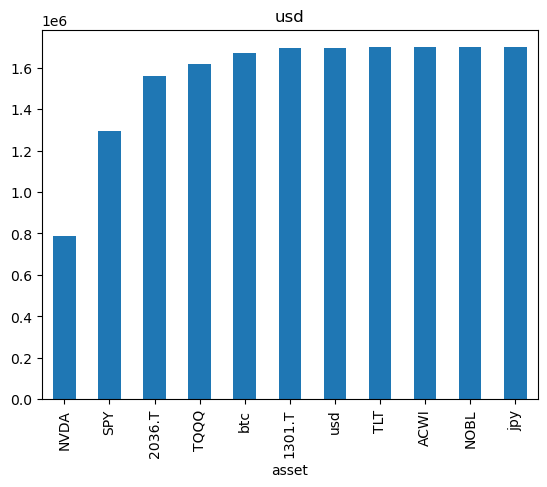

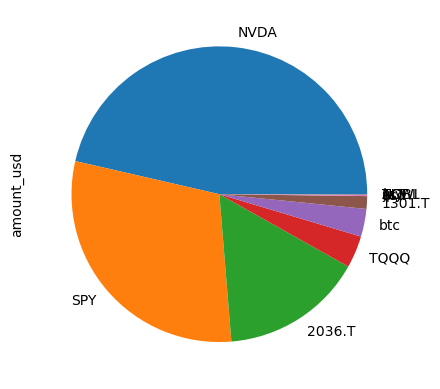

In [158]:
df = pd.read_pickle('/tmp/df_processed2.pkl')

df.groupby('asset')['amount_usd'].sum().sort_values(ascending=False).cumsum().plot.bar()
plt.title('usd')
plt.show()

df.groupby('asset')['amount_usd'].sum().sort_values(ascending=False).plot.pie()
plt.show()

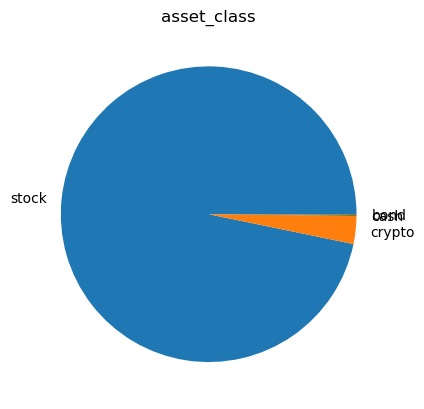

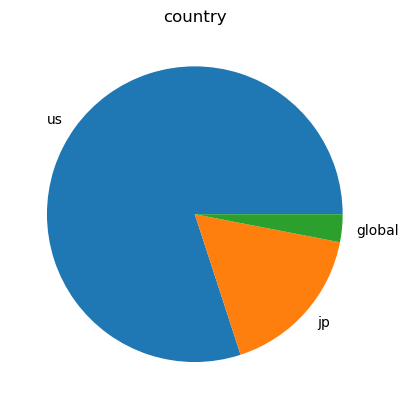

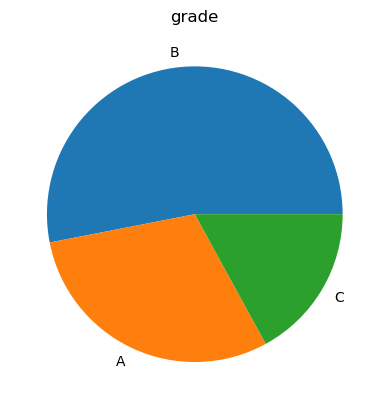

In [159]:
df = pd.read_pickle('/tmp/df_processed2.pkl')

df.groupby('asset_class')['amount_usd'].sum().sort_values(ascending=False).plot.pie(label='', title='asset_class')
plt.show()
df.groupby('country')['amount_usd'].sum().sort_values(ascending=False).plot.pie(label='', title='country')
plt.show()
df.groupby('grade')['amount_usd'].sum().sort_values(ascending=False).plot.pie(label='', title='grade')
plt.show()

## Deviation from the richmanbtc portfolio

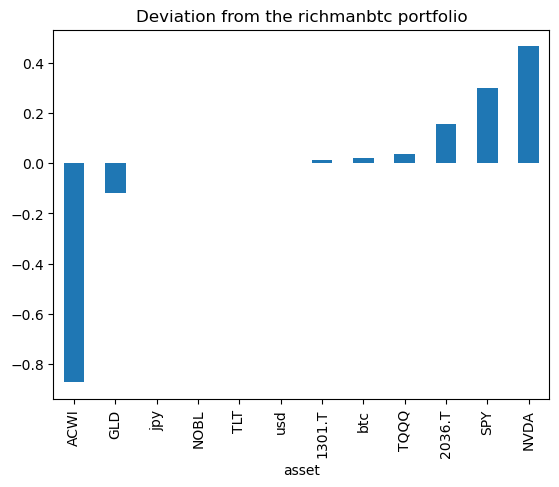

In [160]:
df = pd.read_pickle('/tmp/df_processed2.pkl')
ratio = df.groupby('asset')['amount_usd'].sum()
ratio /= ratio.sum()
ratio = ratio[ratio != 0]

if 'GLD' not in ratio.index:
    ratio['GLD'] = 0.0
ratio['GLD'] -= gold_market_cap / rich_market_cap

vt_like_assets = ['VT', 'ACWI']
rich_stock_ratio = stock_market_cap / rich_market_cap
idx = ratio.index.isin(vt_like_assets)
if not idx.any():
    ratio['VT'] = -rich_stock_ratio
else:
    ratio[idx] -= rich_stock_ratio * ratio[idx] / ratio[idx].sum()

if 'btc' not in ratio.index:
    ratio['btc'] = 0.0
ratio['btc'] -= btc_market_cap / rich_market_cap

ratio.sort_values().plot.bar()
plt.title('Deviation from the richmanbtc portfolio')
plt.show()